# CLUSTERING DE SEMILLAS

## Introducción

En esta practica nos enfocamos en clustering. Clustering es una técnica de aprendizaje no supervisado para organizar en distintos grupos los datos de una semilla, de manera que los datos en un grupo tengan características similares.
Primero usaremos una herramienta llamada PCA para determinar cuál es el mejor scaler para usar con esta semilla y luego aplicaremos distintos modos de agrupamiento con el objetivo de encontrar los hiper-parametros más relevantes y discutir los resultados obtenidos.

#### Integrantes: Javier Díez y Mario Hidalgo

area          0
perimetro     0
compacidad    0
longitud      0
anchura       0
asimetria     0
surco         0
clase         0
dtype: int64 0


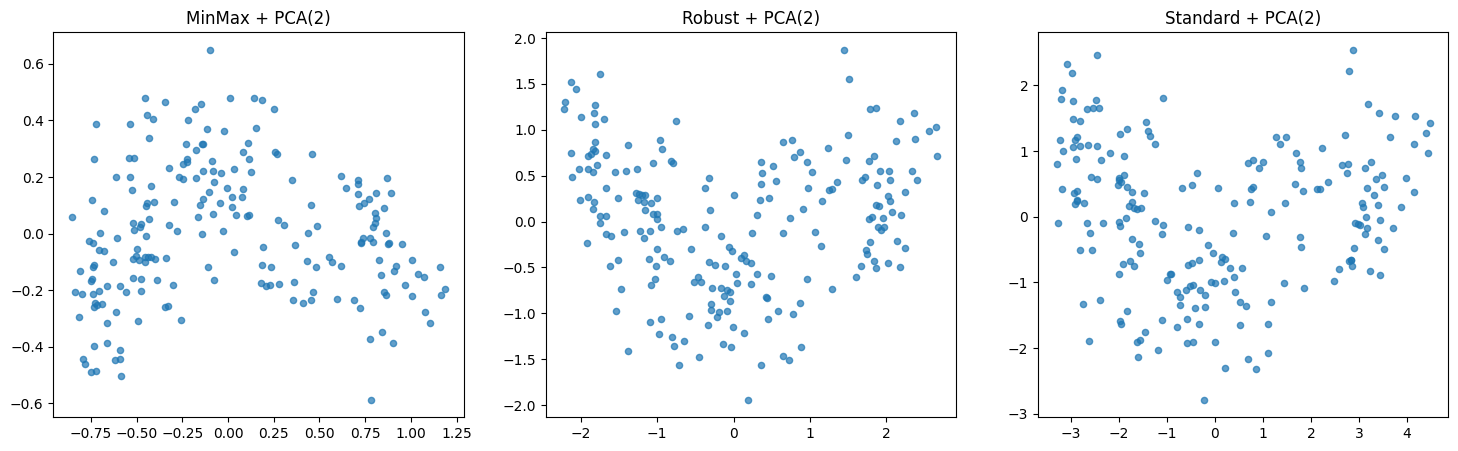

In [ ]:
# ─ Imports básicos ─
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ─ Semilla de reproducibilidad ─
NIA = 100495801
np.random.seed(NIA)

# ─ scikit-learn pipelines y utilidades ─
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors


# ─ Ajustes de visualización ─
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)

# 2. Carga y exploración de datos

# Leer el CSV 
df = pd.read_csv('semillas.csv')  
df.head(), df.describe()

# Comprobar nulos, duplicados…
print(df.isna().sum(), df.duplicated().sum())

# 3. Comparación de scalers con PCA (0.25 p)

scalers = {
    'MinMax': MinMaxScaler(),
    'Robust': RobustScaler(),
    'Standard': StandardScaler()
}

fig, axes = plt.subplots(1, 3, figsize=(18,5))
for ax, (name, scaler) in zip(axes, scalers.items()):
    pipe = make_pipeline(scaler, PCA(n_components=2, random_state=NIA))
    x_scaled = pipe.fit_transform(df.drop('clase', axis=1))
    ax.scatter(x_scaled[:,0], x_scaled[:,1], s=20, alpha=0.7)
    ax.set_title(f'{name} + PCA(2)')
plt.show()


## Evaluación de scalers
De los diferentes scalers, podemos observar que "MinMax" es el que nos da unos parámetros menos amplios ([-0.75, 0.75], [-0.6, 0.6]) y es por tanto el primero que vamos a descartar. En cuanto a los otros dos si bien el "Standard scaler" nos da una mayor amplitu de ejes, existen algunos valores apartados que provocan este estiramiento del eje mientras que en el Robust scaler vemos un poco más de condensación y por tanto será el que elijamos.

## Aplicación de técnicas de clustering

### Tipos de clustering
Los tipos de clustering que vamos a realizar son los siguientes:

- **Basados en centroides**: Asumen que los datos cercanos pertenecen al mismo cluster. Técnica a usar: K-Means.
- **Basados en conectividad**: Forman agrupamientos anidados. Técnicas a usar: dendrogramas y clustering jerárquico.
- **Basados en densidad**: Los clusters son regiones densas de puntos conectados. Técnica a usar: DBSCAN.

### K-Means clustering
Primero aplicamos K-Means sobre los datos proyectados a 2D. Para determinar el número óptimo de clusters, usamos el método del codo y la puntuación de silueta.
El método del codo consiste en calcular la inercia, que es la suma de distancias cuadradas de los puntos a sus centroides, para diferentes valores de k. El objetivo es encontrar el punto donde la reducción de la inercia deja de ser significativa.
Para ello empleamos el uso de la silueta, que es un medidor de cada punto para saber si se encuentra mejor en el cluster en el que está o en otro.

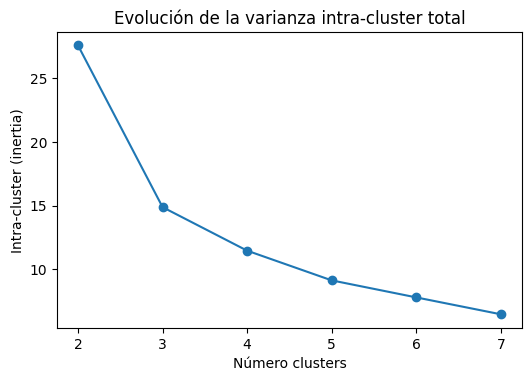

In [227]:
# Primero pasamos el filtro del scaler a los datos
scaler = MinMaxScaler()
pipe = make_pipeline(scaler, PCA(n_components=2, random_state=NIA))
x_scaled = pipe.fit_transform(df.drop('clase', axis=1))

# Método del codo y silueta para K-Means
inertias = []
K_range = range(2, 8)

for n_clusters in K_range:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 42
    )
    modelo_kmeans.fit(x_scaled)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(K_range, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');


Ya que no tenemos muy claro si elegir entre 3 o 4 clústeres, utilizamos el método de la silueta para poder compararlos.

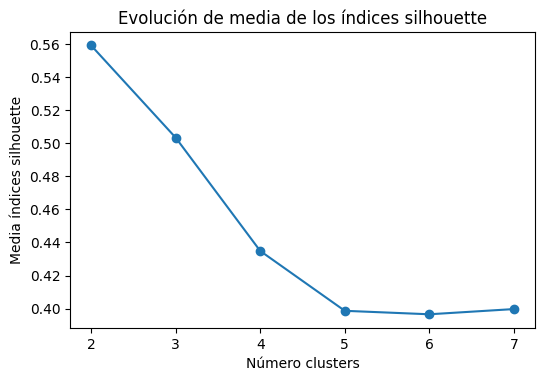

In [228]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
silhouettes = []

for n_clusters in K_range:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 123
    )
    cluster_labels = modelo_kmeans.fit_predict(x_scaled)
    silhouette_avg = silhouette_score(x_scaled, cluster_labels)
    silhouettes.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(K_range, silhouettes, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

Como a simple vista es compicado determinar cuál es el ideal, mezclamos ambos gráficos y comparamos.

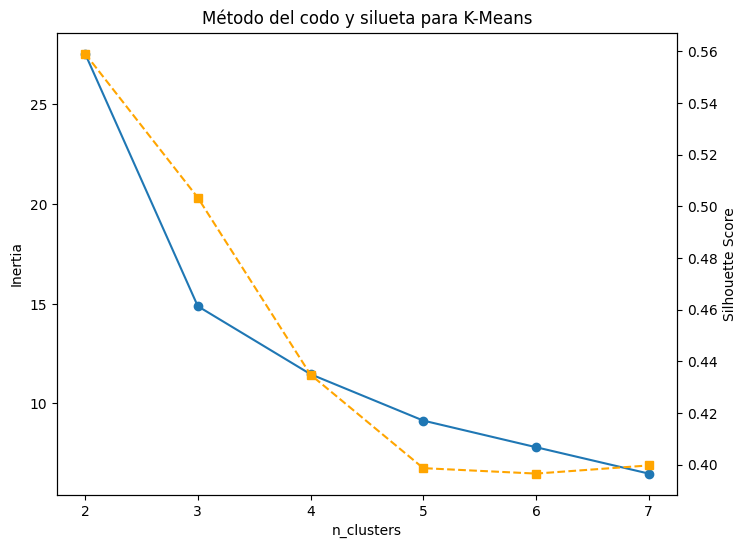

In [229]:
fig, ax1 = plt.subplots()
ax1.plot(K_range, inertias, 'o-', label='Inertia (Codo)')
ax1.set_xlabel('n_clusters')
ax1.set_ylabel('Inertia')
ax2 = ax1.twinx()
ax2.plot(K_range, silhouettes, 's--', color='orange', label='Silhouettes')
ax2.set_ylabel('Silhouette Score')
plt.title('Método del codo y silueta para K-Means')
plt.show()

Al observar el gráfico comprobamos que el mejor número de clusters es 3 ya que es el numero que tiene la mayor diferencia entre las lineas de siluetas (naranja) con respecto de la inercia (azul). En k=3, la silueta está en un punto muy alto, además de que la inercia se encuentra mucho más por debajo que en k=2. Esto indica que la separación entre clusters es buena (la silueta es alta) y la separación entre clusters no afecta tanto (la pendiente a partir de k=3 de la línea de inercia da un cambio drástico).
Ahora visualizamos los clusters resultantes con k=3.

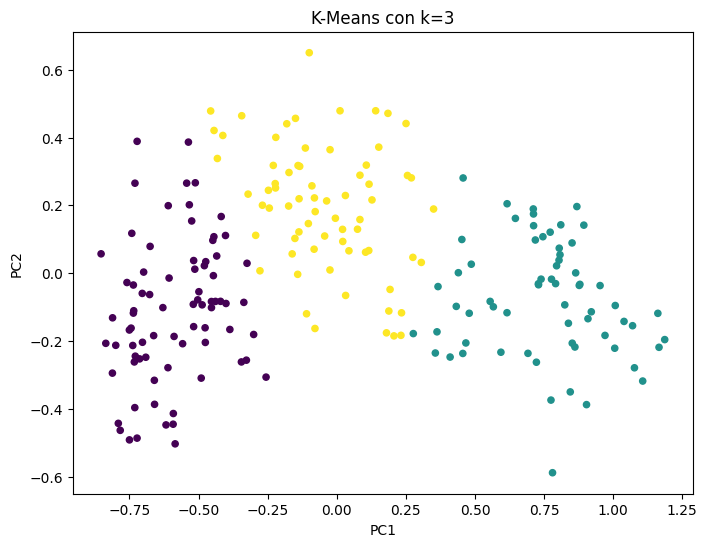

In [230]:
# Aplicar K-Means
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=NIA)
labels_kmeans = kmeans.fit_predict(x_scaled)
plt.scatter(x_scaled[:,0], x_scaled[:,1], c=labels_kmeans, cmap='viridis', s=20)
plt.title(f'K-Means con k={k_opt}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### Clustering jerárquico
Probamos diferentes métodos de linkage ('ward', 'complete', 'average') y visualizamos el dendrograma para cada uno para decidir el número de clusters. Después, mostramos la agrupación resultante para cada método.

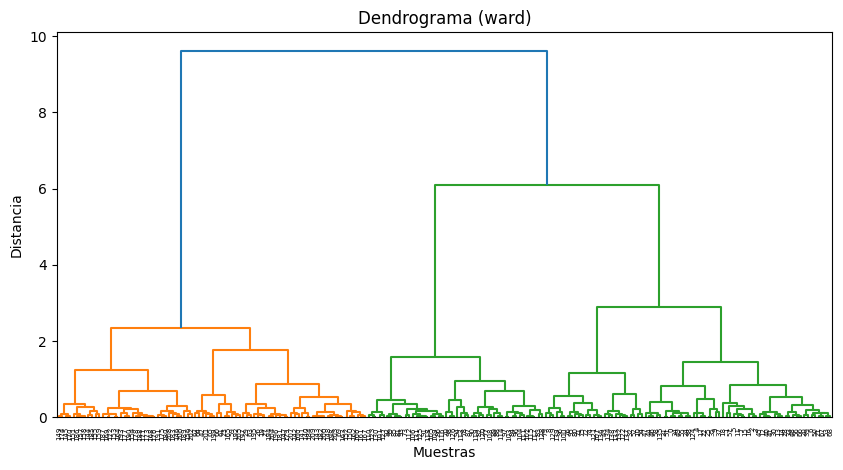

In [231]:
# Dendrograma con linkage 'ward'
Z_ward = linkage(x_scaled, method='ward')
plt.figure(figsize=(10,5))
dendrogram(Z_ward)
plt.title('Dendrograma (ward)')
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.show()

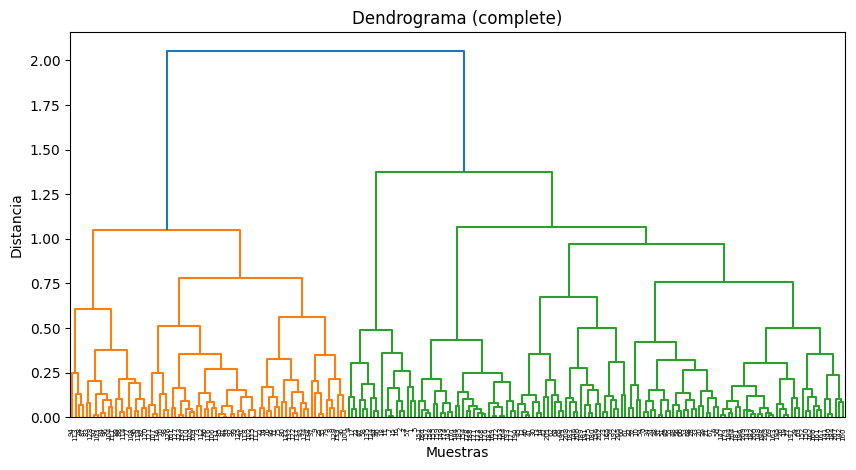

In [232]:
# Dendrograma con linkage 'complete'
Z_complete = linkage(x_scaled, method='complete')
plt.figure(figsize=(10,5))
dendrogram(Z_complete)
plt.title('Dendrograma (complete)')
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.show()

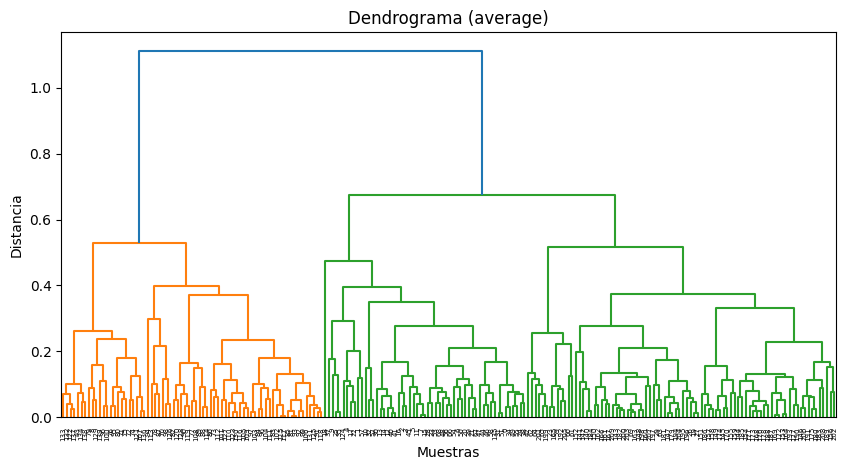

In [233]:
# Dendrograma con linkage 'average'
Z_average = linkage(x_scaled, method='average')
plt.figure(figsize=(10,5))
dendrogram(Z_average)
plt.title('Dendrograma (average)')
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.show()

Para los métodos 'ward' y 'average' usaremos 3 clusters porque, según los dendrogramas, parece ser la mejor división de los atributos. Por otro lado, para 'complete' usaremos 4.
Ahora empleamos dicho número de clusters para cada método de linkage.

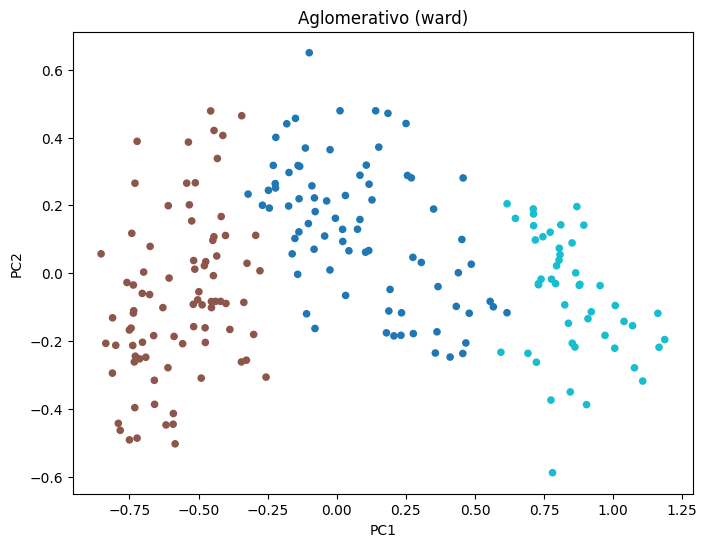

In [234]:
# Visualización de clusters para linkage 'ward'
model_ward = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_ward = model_ward.fit_predict(x_scaled)
plt.scatter(x_scaled[:,0], x_scaled[:,1], c=labels_ward, cmap='tab10', s=20)
plt.title('Aglomerativo (ward)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

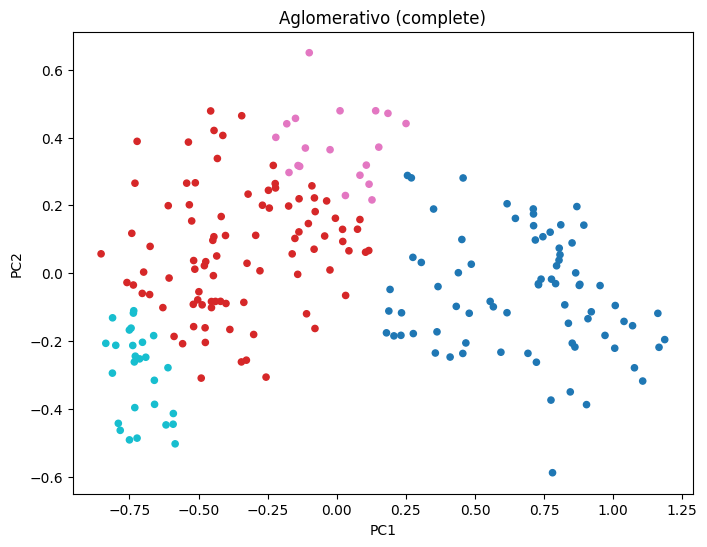

In [235]:
# Visualización de clusters para linkage 'complete'
model_complete = AgglomerativeClustering(n_clusters=4, linkage='complete')
labels_complete = model_complete.fit_predict(x_scaled)
plt.scatter(x_scaled[:,0], x_scaled[:,1], c=labels_complete, cmap='tab10', s=20)
plt.title('Aglomerativo (complete)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

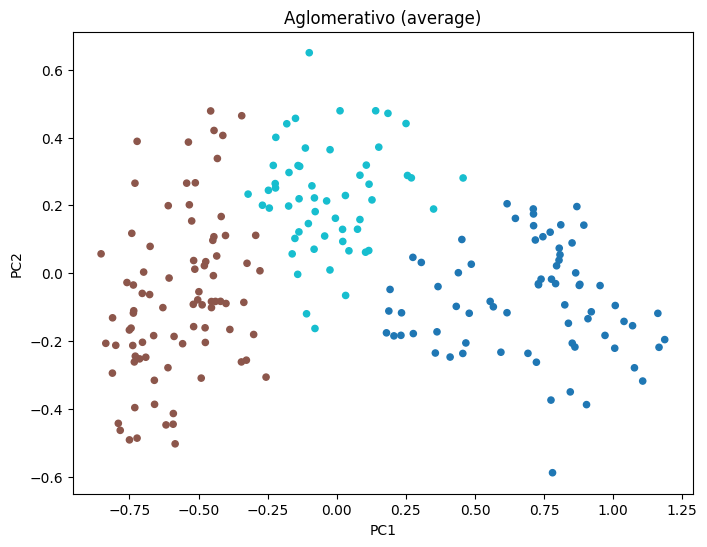

In [236]:
# Visualización de clusters para linkage 'average'
model_average = AgglomerativeClustering(n_clusters=3, linkage='average')
labels_average = model_average.fit_predict(x_scaled)
plt.scatter(x_scaled[:,0], x_scaled[:,1], c=labels_average, cmap='tab10', s=20)
plt.title('Aglomerativo (average)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### DBSCAN
Probamos diferentes valores de eps y min_samples para encontrar la mejor separación de clusters. Por lo general, el min_samples viene dado con 2 * número de dimensiones. Como estamos en 2 dimensiones, min_samples = 4.
Para calcular eps calculamos la distancia al k-ésimo vecino más cercano para cada punto (donde k = min_samples) y se ordenan estas distancias. Elegimos el eps cuya pendiente se cambie más bruscamente.

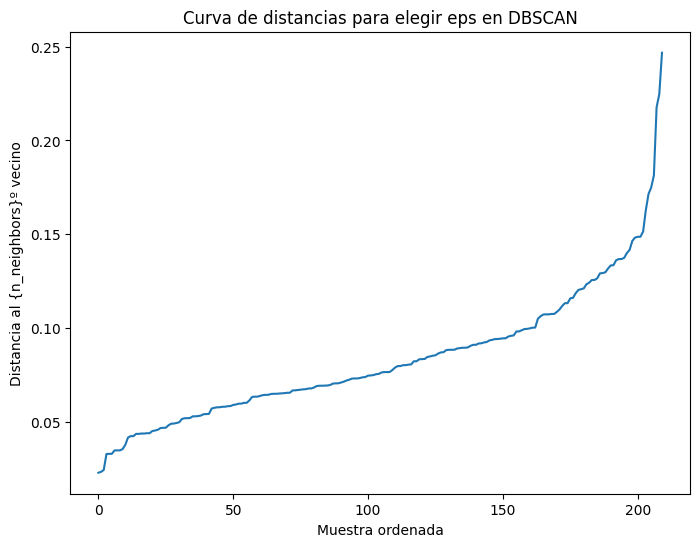

In [276]:
n_neighbors = 2*2 # 2*dimensiones (2D)
neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors_fit = neighbors.fit(x_scaled)
distances, indices = neighbors_fit.kneighbors(x_scaled)
distances = np.sort(distances[:,n_neighbors-1])
plt.plot(distances)
plt.title('Curva de distancias para elegir eps en DBSCAN')
plt.xlabel('Muestra ordenada')
plt.ylabel('Distancia al {n_neighbors}º vecino')
plt.show()

Aproximadamente el eps cuya pendiente cambia más rápidamente es 0.135. Por eso usaremos DBSCAN con dicho valor.

In [277]:
# Modelo
# ==============================================================================
modelo_dbscan = DBSCAN(
    eps          = 0.135,
    min_samples  = 2*2,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X=x_scaled)

DBSCAN(eps=0.135, min_samples=4)

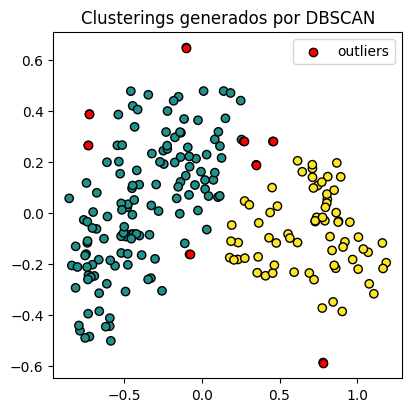

In [278]:
# Clasificación
# ==============================================================================
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = x_scaled[:, 0],
    y = x_scaled[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = x_scaled[labels == -1, 0],
    y = x_scaled[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN');

En general, el ajuste de hiperparámetros es el siguiente:

**K_Means:**

Clusters = 3


**Clustering jerárquico:**

1. Ward: Clusters = 3

2. Complete: Clusters = 4
    
3. Average: Clusters = 3


**DBSCAN:**

min vecinos = 4

eps = 0.55

## Análisis de los datos

Primero descartamos la peor presentación de datos. Esta es DBSCAN ya que los clusters no están concentrados y tiene muchos puntos en un cluster, mientras que los otros dos clusters no tienen muchos puntos.

Por otro lado, ya que el resto de métodos de clustering devuelve de número 3, podemos descartar el método de clustering algomerativo completo.
Finalmente, nos quedamos con 3 elecciones muy similares entre sí: los otros dos métodos de clustering aglomerativo y el k-means.

Basándonos en los datos de las semillas y los datos obtenidos a través de los distintos métodos, podemos concluir que son métodos minimamente acertados ya que existen el mismo número de clusters que de clases en las semillas (3).

Finalmente, usaremos boxplots para representar los datos de los clusters obtenidos. Para ello, buscaremos una variable que pueda determinar las separaciones de los clusters rápidamente. Ejecutamos todas las variables posibles y luego comparamos.

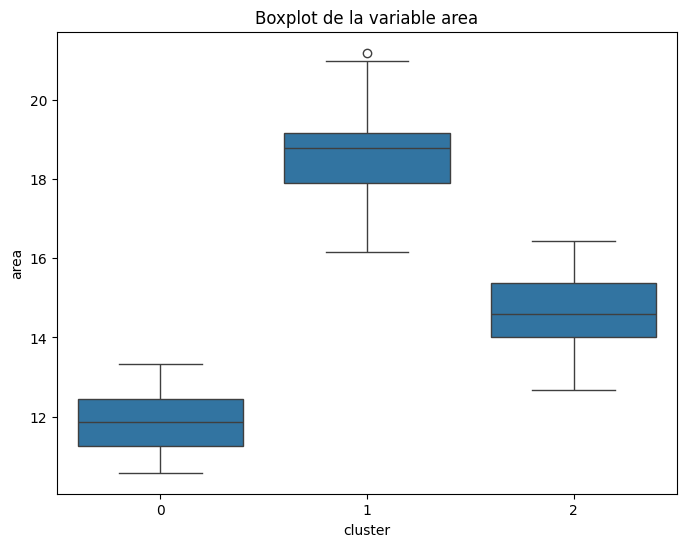

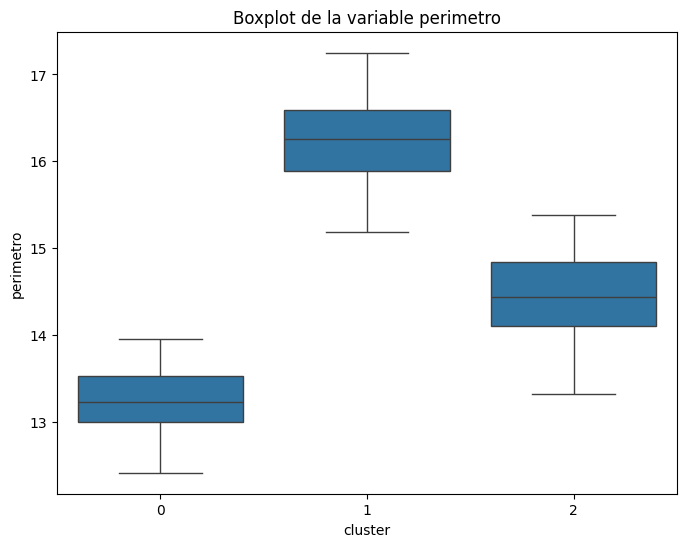

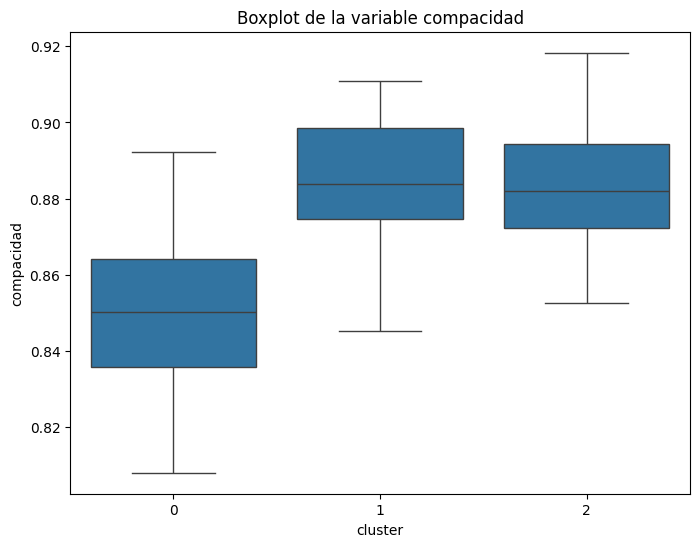

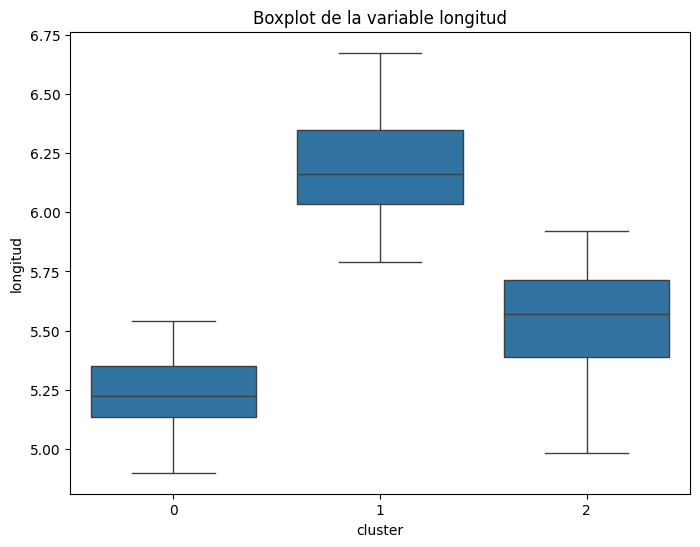

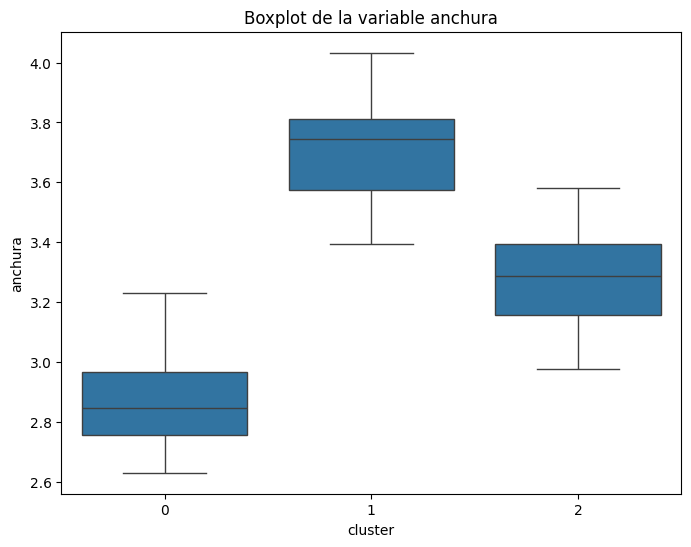

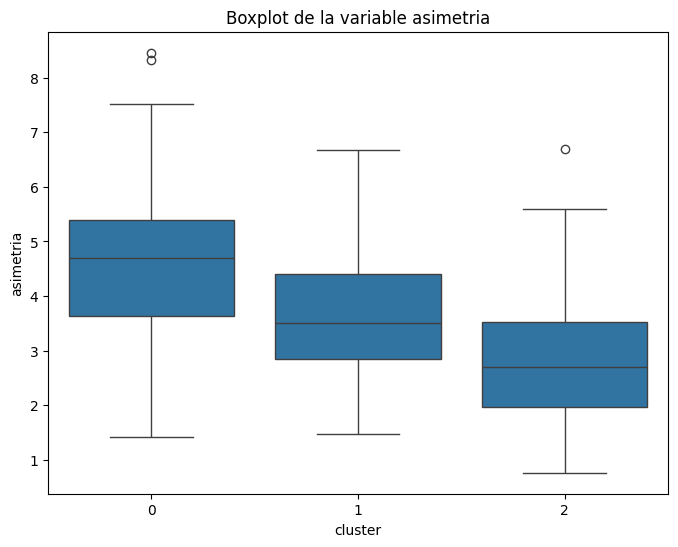

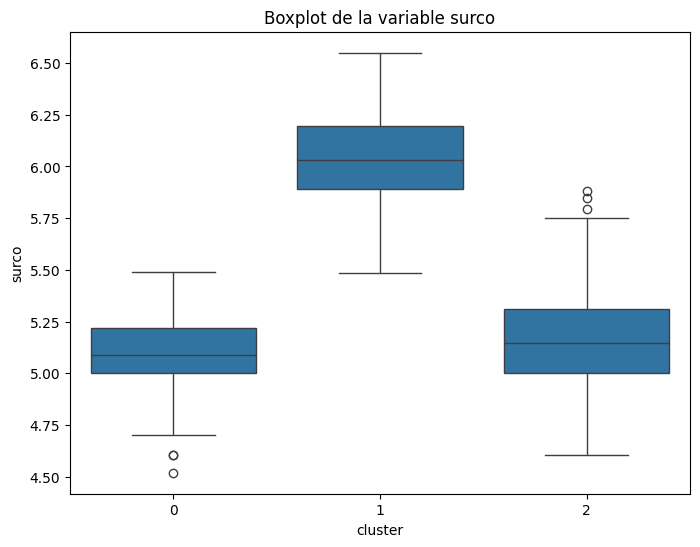

In [279]:
# Boxplot de la variable surco por cluster (usando K-Means para 3 clusters)
variable_tuple = ('area', 'perimetro', 'compacidad', 'longitud', 'anchura', 'asimetria', 'surco')
df_box = df.copy()
df_box['cluster'] = labels_kmeans  # Usa los labels de K-Means (3 clusters)
for i in range(len(variable_tuple)):
    variable = variable_tuple[i]
    sns.boxplot(x='cluster', y=variable, data=df_box, order=sorted(df_box['cluster'].unique()))
    plt.title(f'Boxplot de la variable {variable}')
    plt.xlabel('cluster')
    plt.ylabel(f'{variable}')
    plt.show()

Las variables más significativas son area, perimetro, compacidad y anchura ya que, como se puede comprobar, ninguna de estas boxplot generó outliers, lo que demuestra que es un modelo altamente fiable. Además, la concentración del 50% (las cajas azules) no se superpone en ninguno de los casos, por lo que hay una alta probabilidad de saber cuál es el tipo de semilla teniendo en cuenta cualquiera de estas variables.

Para comprobar si K-Means es el mejor método, ejecutamos el mismo código para las demás labels.

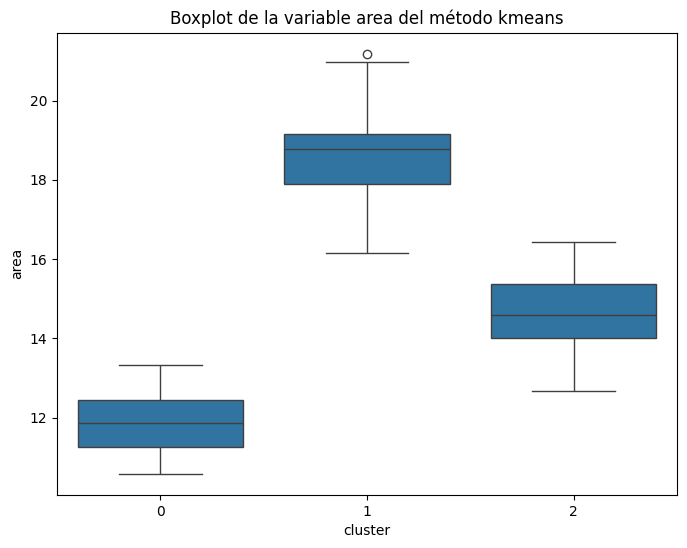

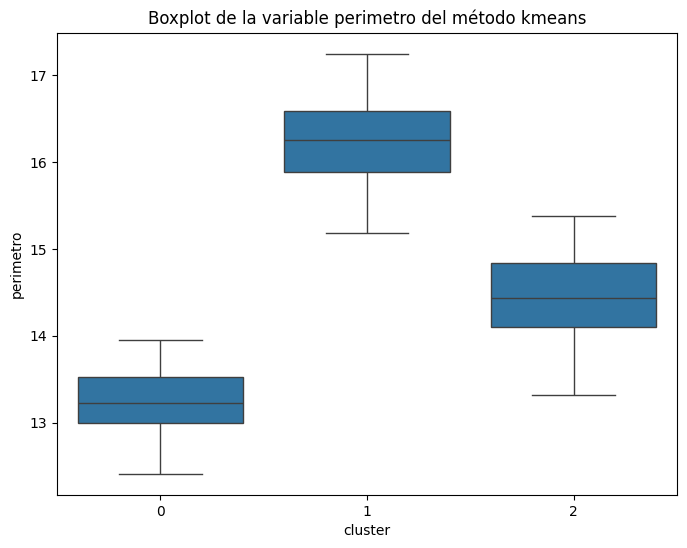

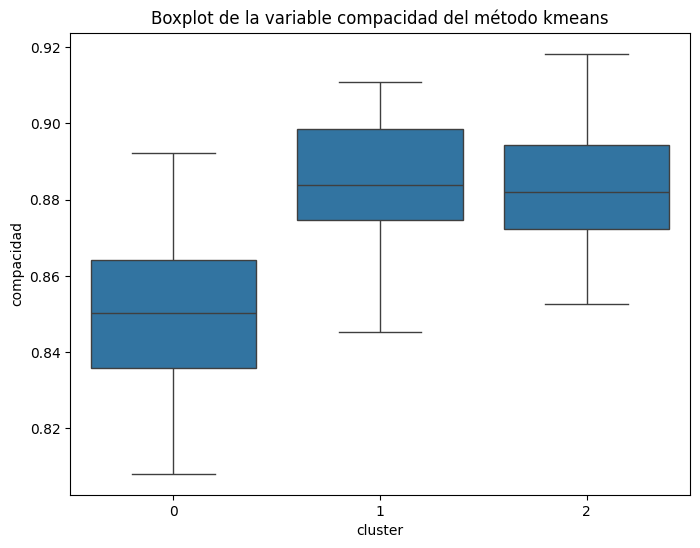

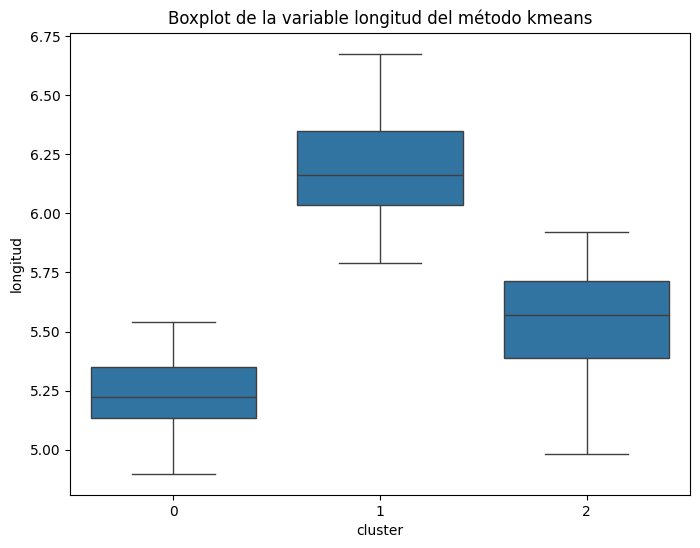

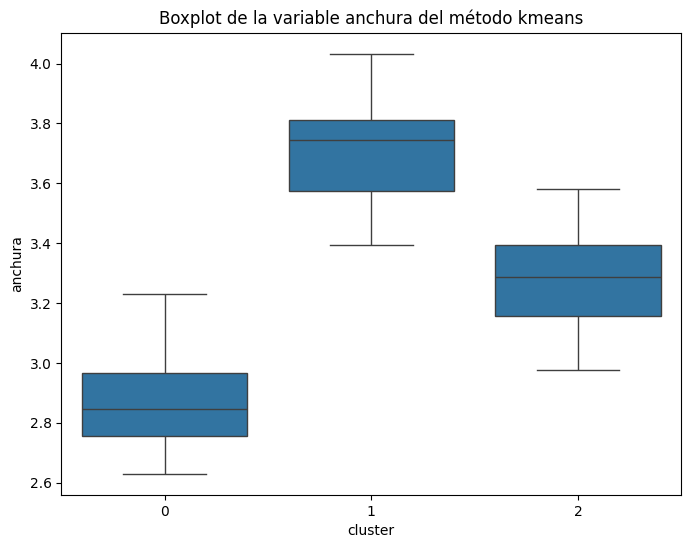

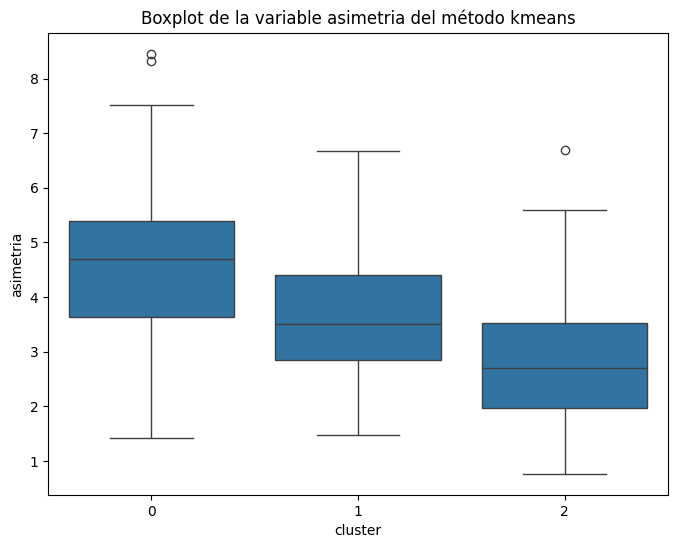

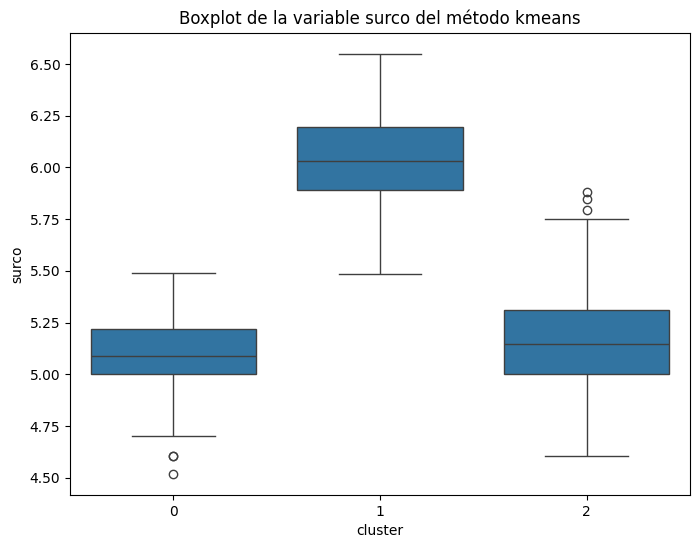

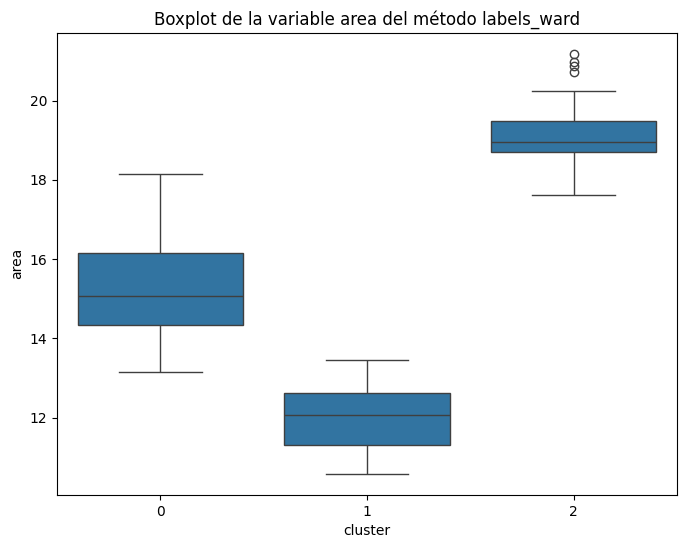

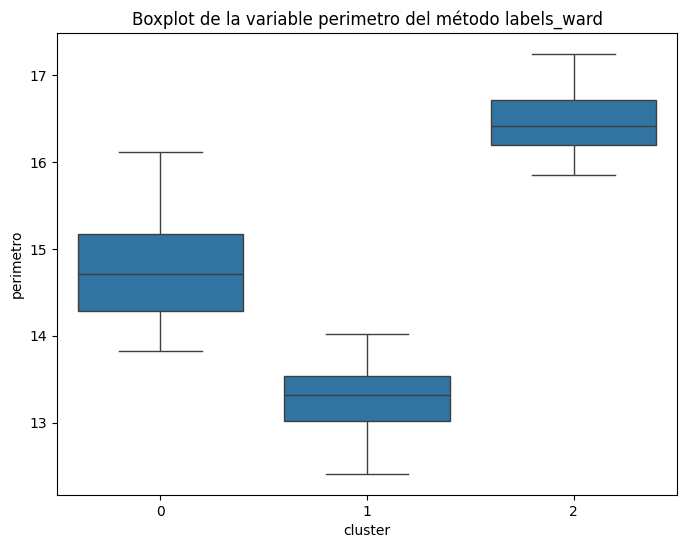

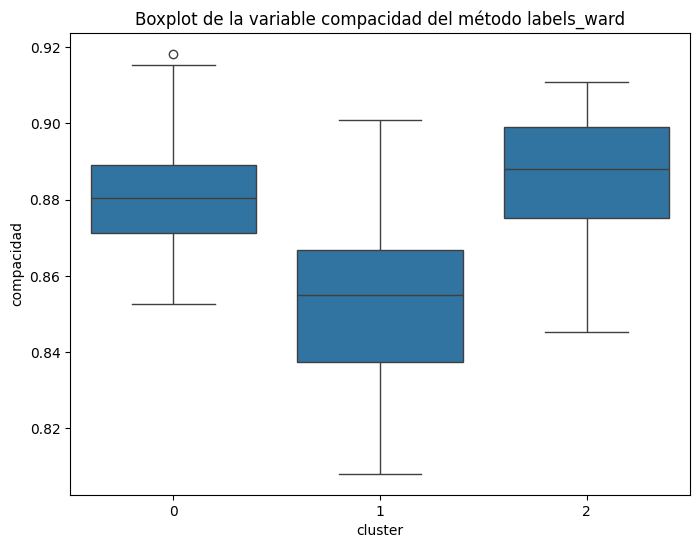

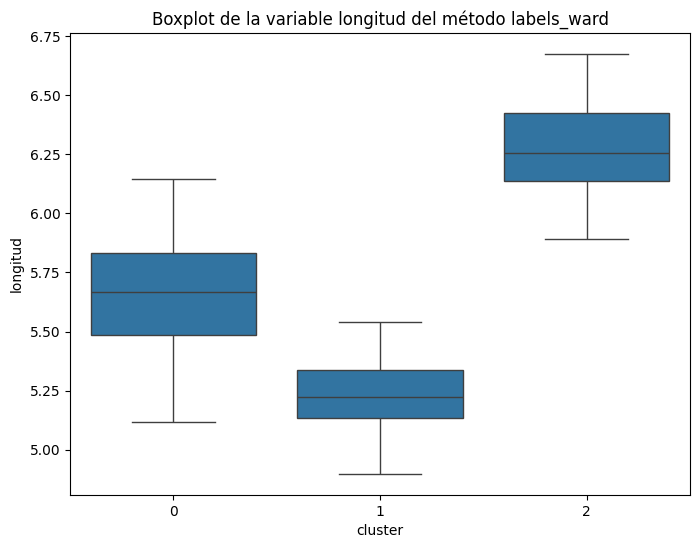

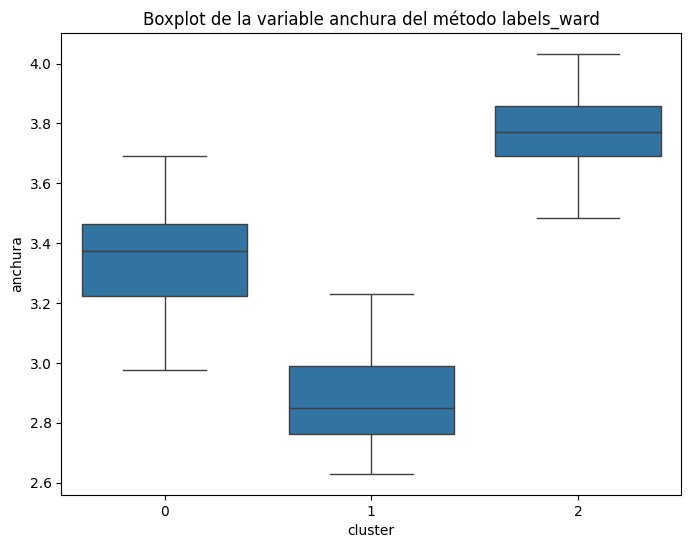

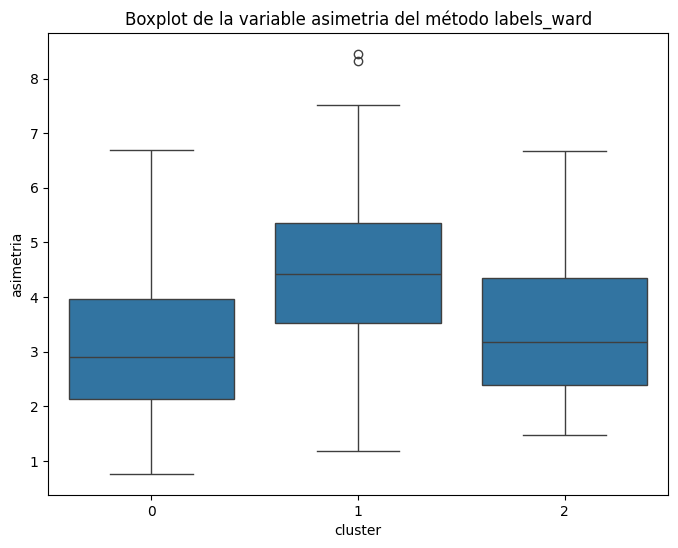

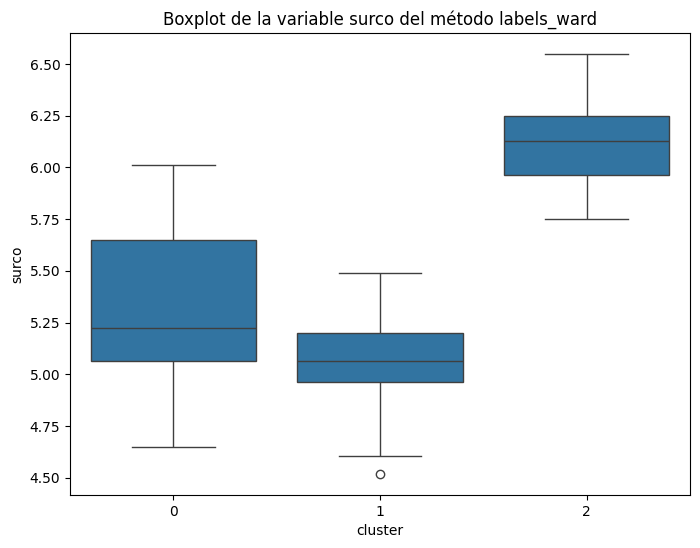

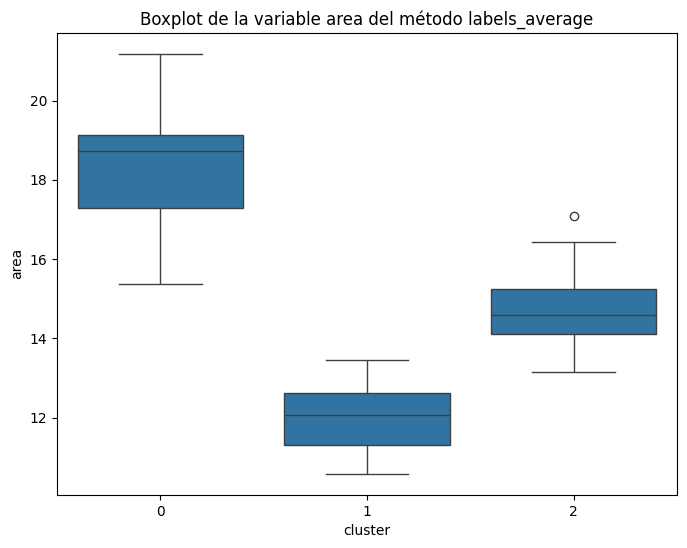

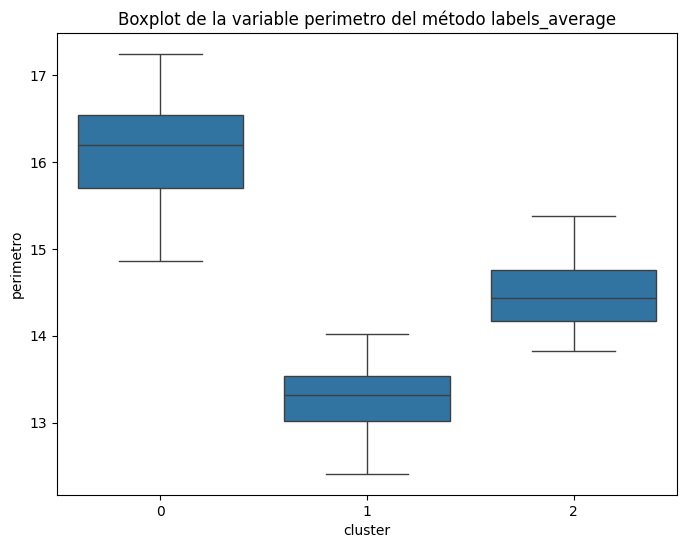

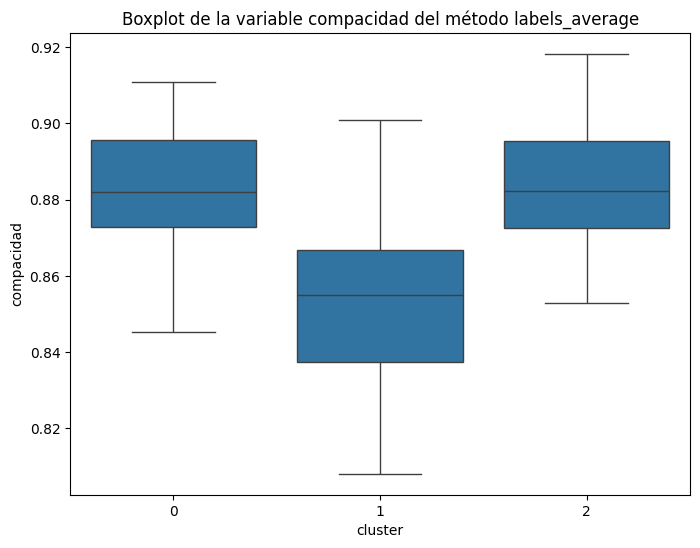

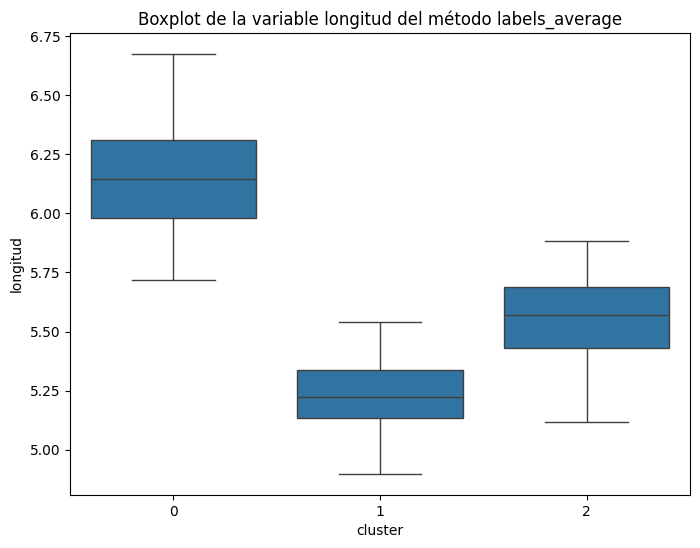

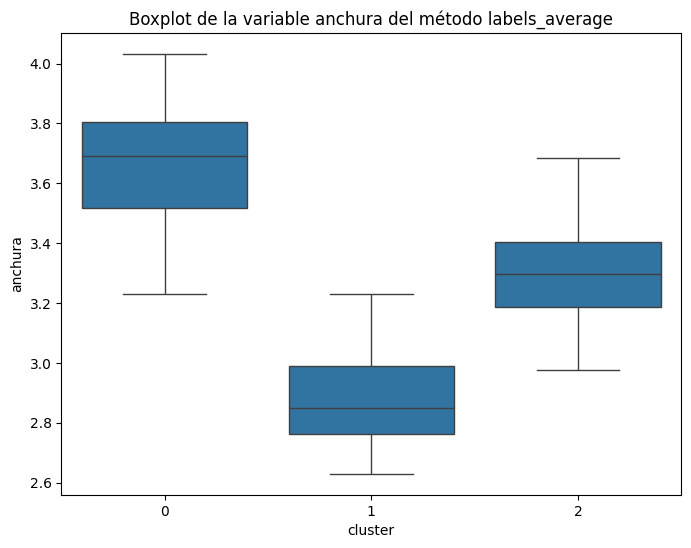

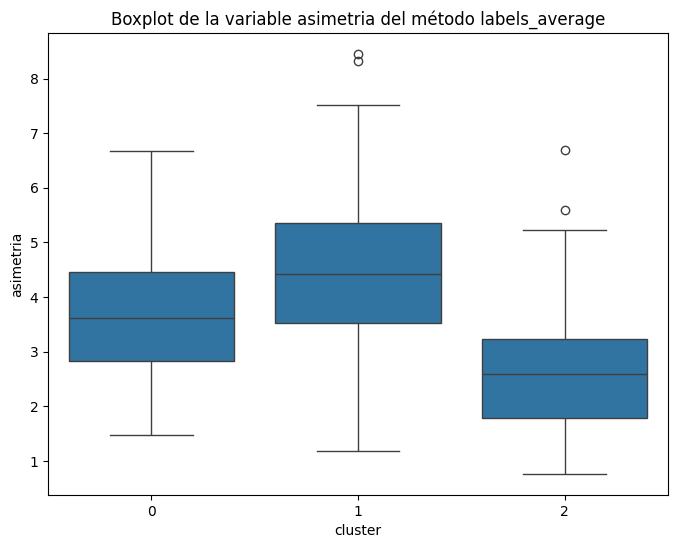

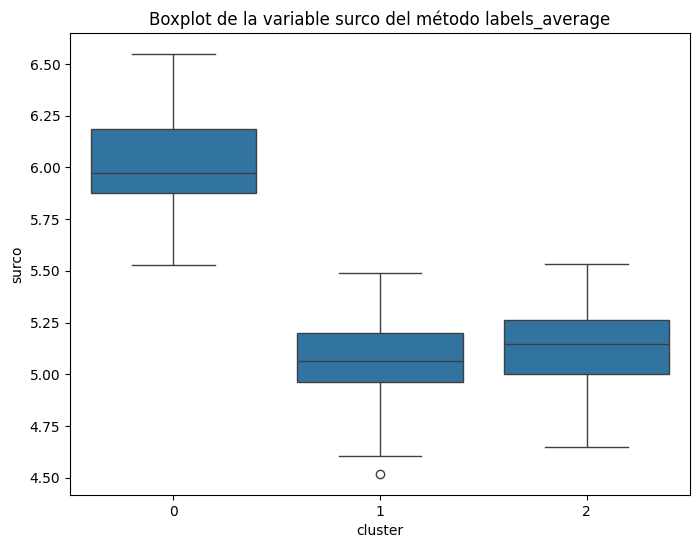

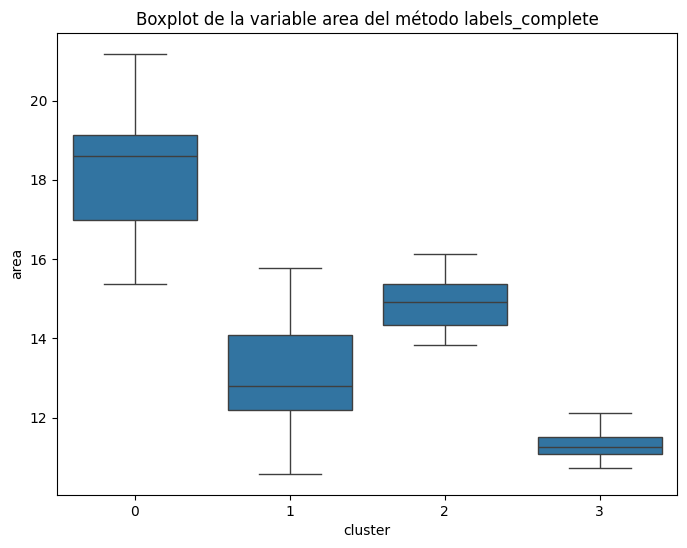

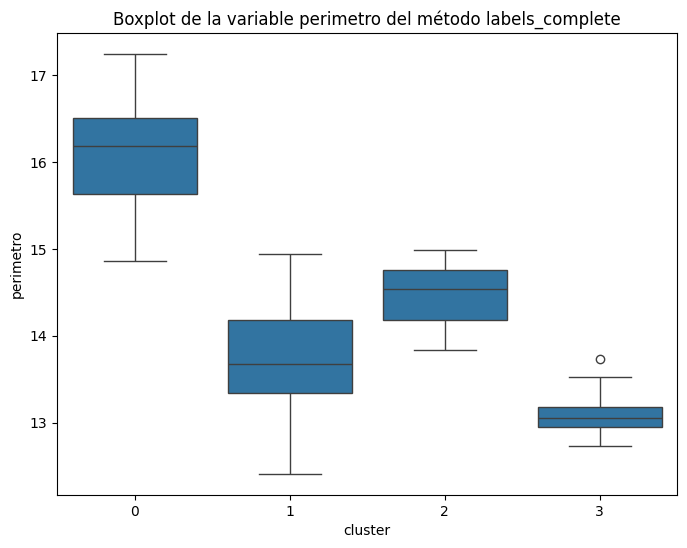

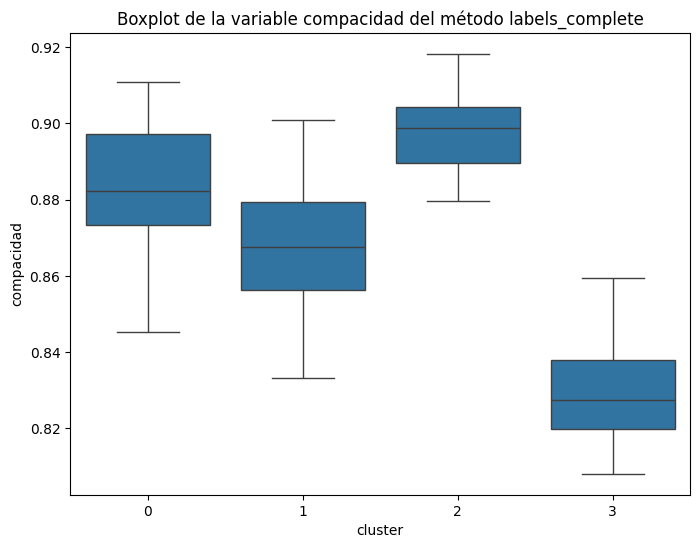

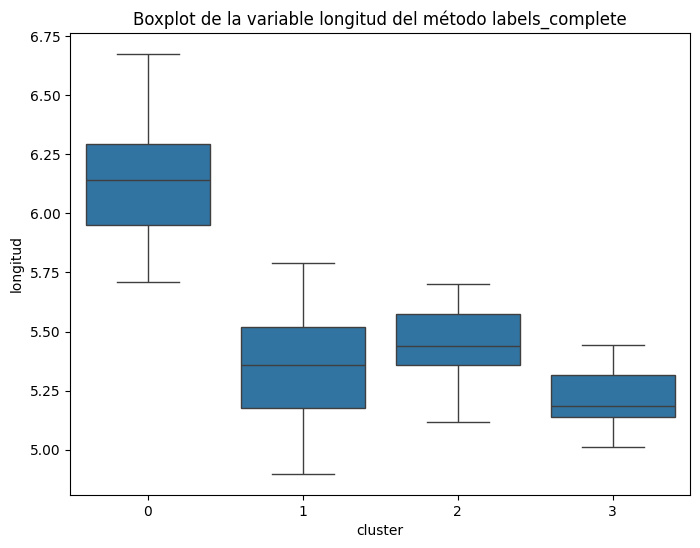

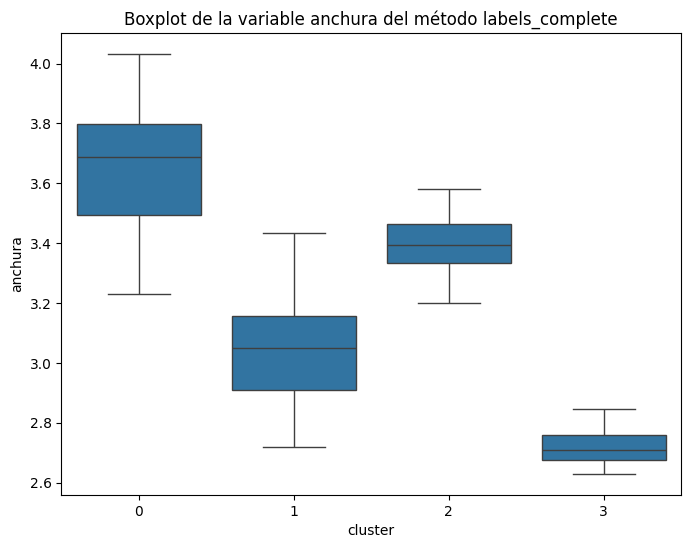

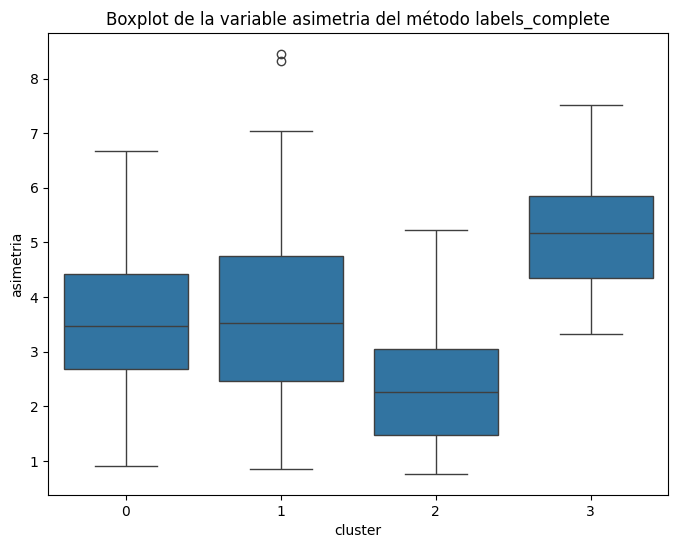

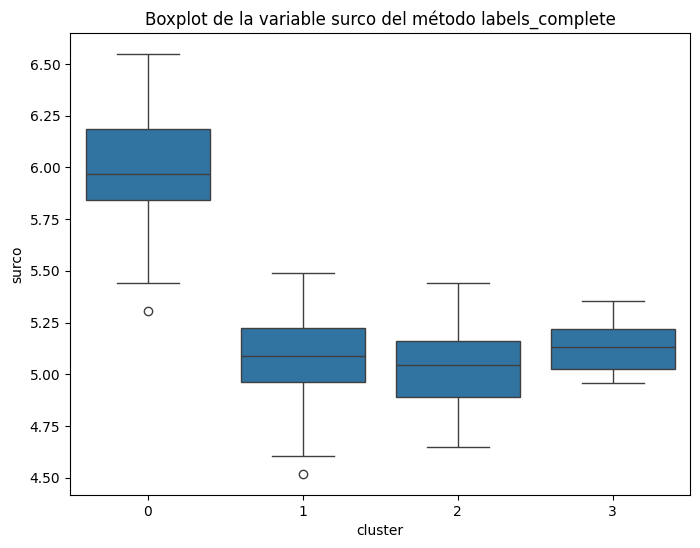

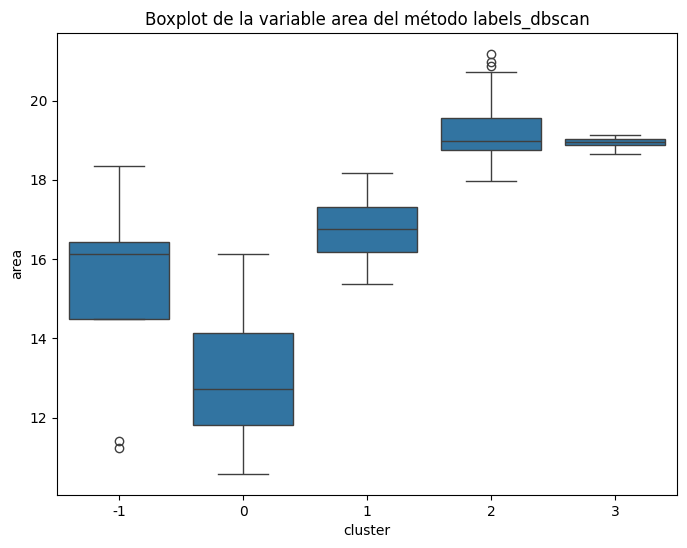

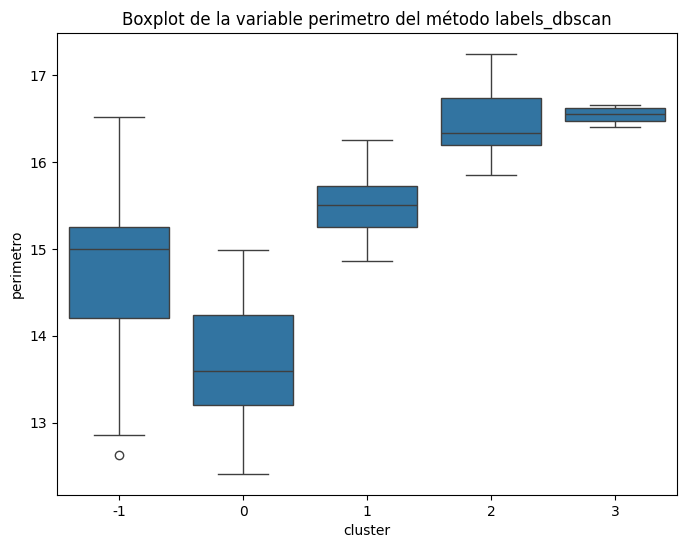

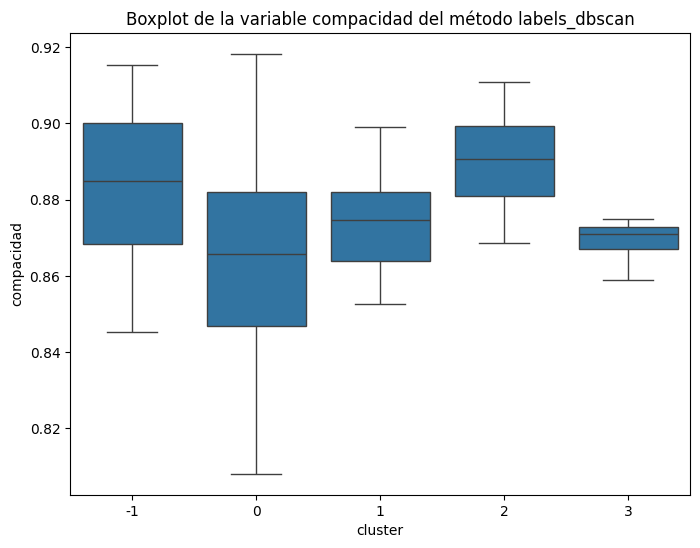

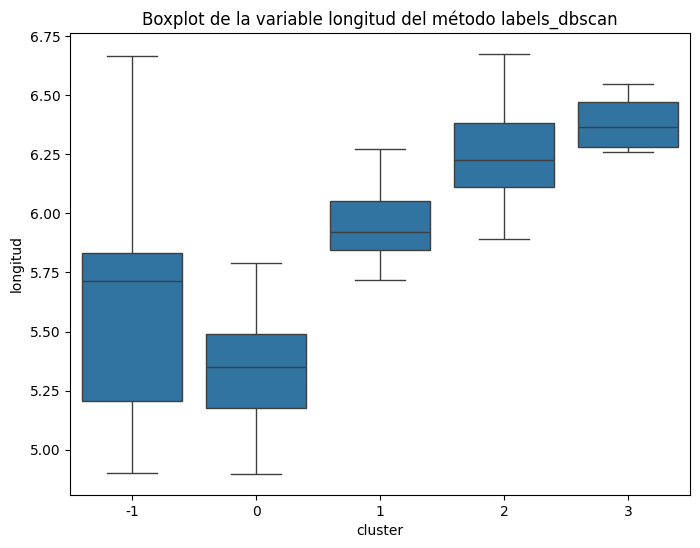

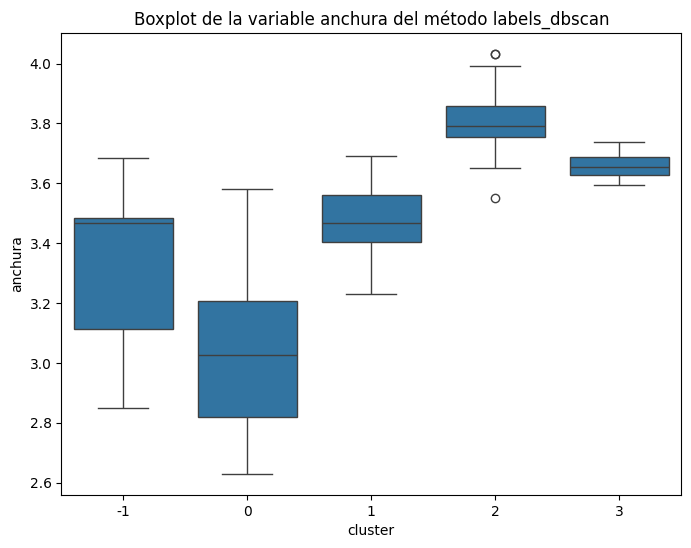

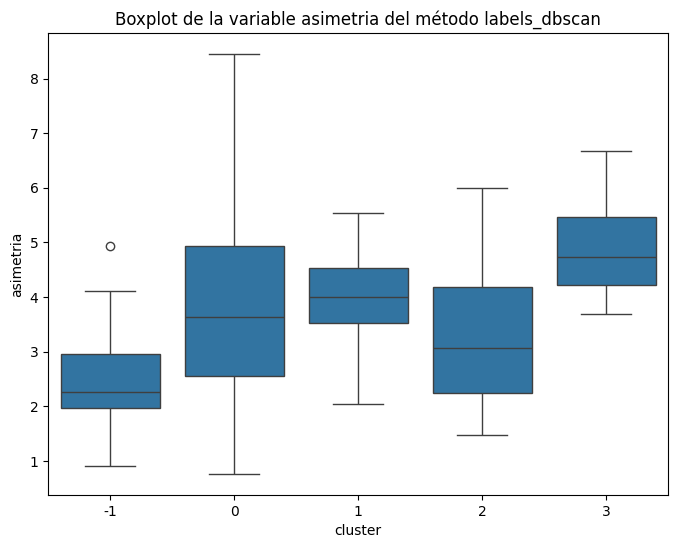

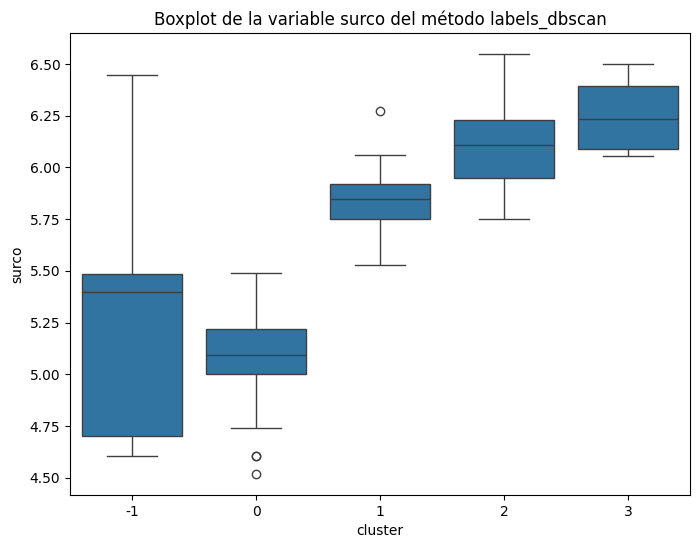

In [280]:
labels_dict = {"kmeans": labels_kmeans, "labels_ward": labels_ward, "labels_average": labels_average, "labels_complete": labels_complete, "labels_dbscan": labels_dbscan}
for element in labels_dict.keys():
    df_box['cluster'] = labels_dict[element]
    for i in range(len(variable_tuple)):
        variable = variable_tuple[i]
        sns.boxplot(x='cluster', y=variable, data=df_box, order=sorted(df_box['cluster'].unique()))
        plt.title(f'Boxplot de la variable {variable} del método {element}')
        plt.xlabel('cluster')
        plt.ylabel(f'{variable}')
        plt.show()

Como hemos encontrado outliers en las variables donde los boxplot de K-Means no producía y, además, no tienen ningún cambio significativo en otras variables, podemos concluir que K-Means es el mejor método de clustering para esta base de datos.

## Conclusión

Esta práctica nos ha ayudado a comprender cómo funcionan los distintos métodos de clustering. En general, hemos aprendido el cómo se operan los distintos métodos de agrupamiento, la gran importancia de los hiper-parámetros en los distintos métodos y la manera de determinar cuál de los métodos es el más efectivo.

Ahora mismo tenemos la ventaja de contar con la clase de semillas, por lo que podemos comprobar si los métodos funcionan correctamente, pero es útil saber de estos resultados por si en un futuro no podamos tener acceso a dichos datos.

Sin embargo, nos resulta extraño que DBSCAN nos proporcione resultados tan extraños. Pensamos que la razó es esta base de datos por lo que, si usasemos otra, podríamos tener resultados que concuerden más con la realidad.